In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage,
)
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from typing_extensions import TypedDict
from typing import Annotated

#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from pydantic import BaseModel, Field
import os

from dotenv import load_dotenv 

#getting current location
import geocoder
from google.oauth2.credentials import Credentials
from googleapiclient.errors import HttpError



load_dotenv()

True

In [2]:
GOOGLE_API_KEY=os.getenv('google_api_key')

In [3]:
GEMINI_MODEL='gemini-2.0-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [4]:
from google.maps import places_v1

In [5]:
if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json")
try:

    client = places_v1.PlacesClient(credentials=creds)

except HttpError as error:
    print(f"An error occurred: {error}")

In [6]:
GOOGLE_API_KEY=os.getenv('google_api_key')

In [7]:
GEMINI_MODEL='gemini-1.5-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [ ]:
class State(TypedDict):
  """
  A dictionnary representing the state of the agent.
  """
  query: str

  #location data
  latitude: str
  longitude: str
  address: str
  route: str
  #results from place search
  places: dict

In [20]:
def router_node(state=State):
    route=state.get('route')
    if route=='look_for_places':
        return 'to_look_for_places' 
    elif route=='current_loc':
        return 'to_current_loc'

In [10]:
# class Form(BaseModel):
#     route: str = Field(description= 'return current_loc or look_for_places')
# parser=JsonOutputParser(pydantic_object=Form)
# instruction=parser.get_format_instructions()
# response=llm.invoke(f'based on this query: look for cool bars in nyc, return current_loc or look_for_places'+'\n\n'+instruction)
# response=parser.parse(response.content)

In [11]:
# response

In [12]:

def get_current_location_node(state: State):
    """
    Tool to get the current location of the user.
    agrs: none
    """
    current_location = geocoder.ip("me")
    if current_location.latlng:
        latitude, longitude = current_location.latlng
        address = current_location.address
        return {
            'latitude':latitude,
            'longitude':longitude,
            'address':address}
    else:
        return 'failed'

In [13]:

def look_for_places_node(state: State):
    """
    Tool to look for places based on the user query and location.
    Use this tool for more complex user queries like sentences, and if the location is specified in the query.
    Places includes restaurants, bars, speakeasy, games, anything.
    args: query - the query.
    Alaways include the links in the response
    """
    try:
        request=places_v1.SearchTextRequest(text_query=state['query'])
        response=client.search_text(request=request,metadata=[("x-goog-fieldmask", "places.displayName,places.formattedAddress,places.priceLevel,places.googleMapsUri")]) 
        places={}
        for i in response.places:
            address=i.formatted_address
            name=i.display_name.text
            price_level=i.price_level
            url=i.google_maps_uri
            places[name]={'address':address,
                        'price_level':price_level,
                        'google_maps_url':url}
                
        return {'places':places}
                               
    except: 
        return "failed"

In [14]:
@tool
def show_places_found(state: Annotated[dict, InjectedState],tool_call_id: Annotated[str, InjectedToolCallId]):
    """
    Tool to get the places found and to show/display them.
    It has links within that can also be used for directions
    args: none
    """
    try:
        return Command(update={'messages': [ToolMessage(state['places'],tool_call_id=tool_call_id)]})
    except:
        return Command(update={ 'messages':[ToolMessage(f'No places to show', tool_call_id=tool_call_id)]})

In [ ]:
class maps_agent:
    def __init__(self,llm: any):
        self.agent=self._setup(llm)
        

    def _setup(self,llm):
        # langgraph_tools=[get_current_location_tool,look_for_places, show_places_found]
        def agent_node(state:State):
            class Form(BaseModel):
                route: str = Field(description= 'return current_loc or look_for_places')
            parser=JsonOutputParser(pydantic_object=Form)
            instruction=parser.get_format_instructions()
            response=llm.invoke([HumanMessage(content=f'based on this query:{state['query']}, return current_loc or look_for_places'+'\n\n'+instruction)])
            response=parser.parse(response.content)
            response=response.get('route')
            return {'route':response}

        graph_builder = StateGraph(State)
        
        # Modification: tell the LLM which tools it can call
        # llm_with_tools = llm.bind_tools(langgraph_tools)
        # tool_node = ToolNode(tools=langgraph_tools)
        # def chatbot(state: State):
        #     """ maps assistant that answers user questions about locations or maps.
        #     Depending on the request, leverage which tools to use if necessary."""
        #     return {"messages": [llm_with_tools.invoke(state['messages'])]}

        # graph_builder.add_node("chatbot", chatbot)

 
        # graph_builder.add_node("tools", tool_node)
        # # Any time a tool is called, we return to the chatbot to decide the next step
        # graph_builder.set_entry_point("chatbot")

        # graph_builder.add_edge("tools", "chatbot")
        # graph_builder.add_conditional_edges(
        #     "chatbot",
        #     tools_condition,
        # )

        graph_builder.add_node('current_loc', get_current_location_node)
        graph_builder.add_node('look_for_places',look_for_places_node)
        
        graph_builder.add_node('agent',agent_node)
        graph_builder.add_edge(START,'agent')
        graph_builder.add_conditional_edges('agent',router_node,{'to_current_loc':'current_loc', 'to_look_for_places':'look_for_places'})
        graph_builder.add_edge('current_loc',END)
        graph_builder.add_edge('look_for_places',END)
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory)
        return graph
    
    def display_graph(self):
        return display(
            Image(
                    self.agent.get_graph().draw_mermaid_png(
                        draw_method=MermaidDrawMethod.API,
                    )
                )
            )
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]
    
    # def stream(self,input:str):
    #     config = {"configurable": {"thread_id": "1"}}
    #     input_message = HumanMessage(content=input)
    #     for event in self.agent.stream({"messages": [input_message]}, config, stream_mode="values"):
    #         event["messages"][-1].pretty_print()

    # def chat(self,input:str):
    #     config = {"configurable": {"thread_id": "1"}}
    #     response=self.agent.invoke({'messages':HumanMessage(content=str(input))},config)
    #     return response['messages'][-1].content
    def chat(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'query':input},config)
        return response

    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        for event in self.agent.stream({'query':input}, config, stream_mode="updates"):
            print(event)
    
    

In [24]:
test=maps_agent(llm)

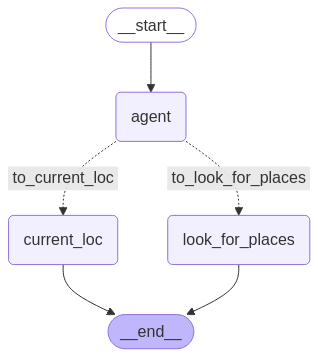

In [25]:
test.display_graph()

In [27]:
test.chat('look for cool bars in manhattan')

{'query': 'look for cool bars in manhattan',
 'places': {'The Dead Rabbit, New York City': {'address': '30 Water St, New York, NY 10004, USA',
   'price_level': <PriceLevel.PRICE_LEVEL_MODERATE: 3>,
   'google_maps_url': 'https://maps.google.com/?cid=16891641895788260568'},
  'Old Town Bar': {'address': '45 E 18th St, New York, NY 10003, USA',
   'price_level': <PriceLevel.PRICE_LEVEL_MODERATE: 3>,
   'google_maps_url': 'https://maps.google.com/?cid=5187821856869086756'},
  'NOTHING REALLY MATTERS': {'address': 'IN THE SUBWAY, 210 W 50th St, New York, NY 10019, USA',
   'price_level': <PriceLevel.PRICE_LEVEL_MODERATE: 3>,
   'google_maps_url': 'https://maps.google.com/?cid=15897906807650872440'},
  'Dear Irving on Hudson Rooftop Bar': {'address': '310 W 40th St, New York, NY 10018, USA',
   'price_level': <PriceLevel.PRICE_LEVEL_EXPENSIVE: 4>,
   'google_maps_url': 'https://maps.google.com/?cid=16303086797466163471'},
  'The Dickens': {'address': '783 8th Ave, New York, NY 10036, USA',

In [ ]:
test.get_state('messages')

[HumanMessage(content='find some vegetarian restaurants in chelsea', additional_kwargs={}, response_metadata={}, id='70a6ce64-b937-492e-af40-70b783888473'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'show_places_found', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-442e7b94-c993-4707-a5b6-7864d795377d-0', tool_calls=[{'name': 'look_for_places', 'args': {'query': 'vegetarian restaurants in chelsea'}, 'id': 'dcd4ab01-1344-4e1a-8677-85222a1649ce', 'type': 'tool_call'}, {'name': 'show_places_found', 'args': {}, 'id': '47433cf8-8413-4d00-86e5-cfda2c82b7fe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 136, 'output_tokens': 15, 'total_tokens': 151, 'input_token_details': {'cache_read': 0}}),
 ToolMessage(content='I found 20 places', name='look_for_places', id='0871a246-ddd2-45b9-aca5-6e416d04f767', tool_call_id='dcd4ab01-1344-4e1a-8677-85222a1649